# Machine Translation with encoder-decoder transformer model


This tutorial is adapted from [Keras' documentation on English-to-Spanish translation with a sequence-to-sequence Transformer](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/), which is itself an adaptation from the book [Deep Learning with Python, Second Edition by François Chollet](https://www.manning.com/books/deep-learning-with-python-second-edition)

We step through an encoder-decoder transformer in JAX and train a model for English->Spanish translation.

In [98]:
%pip install numpy tiktoken flax tqdm grain optax matplotlib jax

/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [99]:
import dataclasses
import pathlib
import random
import re
import string

import grain.python as grain
import jax.numpy as jnp
import numpy as np
import optax
import tiktoken
import tqdm
from flax import nnx

## Pull down data to temp and extract into memory

There are lots of ways to get this done, but for simplicity and clear visibility into what's happening this is downloaded to a temporary directory, extracted there, and read into a python object with processing.

### Libraries Used:
* **tempfile**: Used to create temporary directories to store the dataset during processing.
* **zipfile**: Used to extract the contents of the downloaded zip file.
* **requests**: Used to fetch the raw dataset file from the URL.

### Process Overview:
We extract the zip data into a folder on the local environment. During this process, we apply a critical formatting step to the Spanish target data:

> `"[start] " + spa + " [end]"`

### Why do we do this? (Teacher Forcing)
This is essential for the **Decoder** (the part of the AI generating the Spanish translation). It needs explicit instructions on when to begin generating text and when to stop.

* **[start]:** Tells the model, "Begin generating the first word now."
* **[end]:** Tells the model, "The sentence is complete; stop generating."

In [100]:
import tempfile
import zipfile

import requests

url = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"

with tempfile.TemporaryDirectory() as temp_dir:
    temp_path = pathlib.Path(temp_dir)
    zip_file_path = temp_path / "spa-eng.zip"

    response = requests.get(url)
    zip_file_path.write_bytes(response.content)

    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(temp_path)

    text_file = temp_path / "spa-eng" / "spa.txt"

    with open(text_file) as f:
        lines = f.read().split("\n")[:-1]
    text_pairs = []
    for line in lines:
        eng, spa = line.split("\t")
        spa = "[start] " + spa + " [end]"
        text_pairs.append((eng, spa))

## Build train/validate/test pair sets


We partition the dataset into three distinct subsets: **Training**, **Validation**, and **Test**.

* **Validation Data (15%):** Used to evaluate the model during training to tune hyperparameters and prevent overfitting.
* **Test Data (15%):** Reserved for the final evaluation to check how the model performs on completely unseen data.
* **Training Data (70%):** The remaining data used to actually teach the model.

In [101]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


# Tokenization

This step is crucial because computers and machines do not understand English words directly; they require a **numeric representation** to process language.

To achieve this, we use the **Tiktoken** library developed by **OpenAI**. specifically utilizing the `cl100k_base` dictionary.

* **Tiktoken:** A fast BPE (Byte Pair Encoding) tokenizer.
* **cl100k_base:** A vocabulary containing approximately **100,000 tokens**, where every unique word or word fragment is mapped to a specific integer.

We strip out punctuation to keep things simple and in line with the original tutorial - the `[` `]` are kept in so that our `[start]` and `[end]` formatting is preserved.

In [102]:
tokenizer = tiktoken.get_encoding("cl100k_base")

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = tokenizer.n_vocab
sequence_length = 20

In [103]:
def custom_standardization(input_string):
    lowercase = input_string.lower()
    return re.sub(f"[{re.escape(strip_chars)}]", "", lowercase)

In [104]:
def tokenize_and_pad(text, tokenizer, max_length):
    tokens = tokenizer.encode(text)[:max_length]
    padded = (
        tokens + [0] * (max_length - len(tokens)) if len(tokens) < max_length else tokens
    )  ##assumes list-like - (https://github.com/openai/tiktoken/blob/main/tiktoken/core.py#L81 current tiktoken out)
    return padded

In [105]:
def format_dataset(eng, spa, tokenizer, sequence_length):
    eng = custom_standardization(eng)
    spa = custom_standardization(spa)
    eng = tokenize_and_pad(eng, tokenizer, sequence_length)
    spa = tokenize_and_pad(spa, tokenizer, sequence_length)
    return {
        "encoder_inputs": eng,
        "decoder_inputs": spa[:-1],
        "target_output": spa[1:],
    }

In [106]:
train_data = [format_dataset(eng, spa, tokenizer, sequence_length) for eng, spa in train_pairs]
val_data = [format_dataset(eng, spa, tokenizer, sequence_length) for eng, spa in val_pairs]
test_data = [format_dataset(eng, spa, tokenizer, sequence_length) for eng, spa in test_pairs]

At this point we've extracted the data, applied formatting, and tokenized the phrases with padding. The data is kept in train/validate/test sets that each have dictionary entries, which look like the following:

In [107]:
## data selection example
print(train_data[135])

{'encoder_inputs': [30115, 2664, 9711, 757, 1523, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'decoder_inputs': [29563, 60, 12067, 658, 29452, 757, 32895, 10872, 689, 510, 408, 60, 0, 0, 0, 0, 0, 0, 0], 'target_output': [60, 12067, 658, 29452, 757, 32895, 10872, 689, 510, 408, 60, 0, 0, 0, 0, 0, 0, 0, 0]}


The output should look something like

{'encoder_inputs': [9514, 265, 3339, 264, 2466, 16930, 1618, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'decoder_inputs': [29563, 60, 1826, 7206, 71086, 37116, 653, 16109, 1493, 54189, 510, 408, 60, 0, 0, 0, 0, 0, 0], 'target_output': [60, 1826, 7206, 71086, 37116, 653, 16109, 1493, 54189, 510, 408, 60, 0, 0, 0, 0, 0, 0, 0]}

## Define Transformer components: Encoder, Decoder, Positional Embed

In many ways this is very similar to the original source, with `ops` changing to `jnp` and `keras` or `layers` becoming `nnx`. Certain module-specific arguments come and go, like the rngs attached to most things in the updated version, and decode=False in the MultiHeadAttention call.

In [108]:
@dataclasses.dataclass
class TransformerConfig:
    sequence_length: int
    vocab_size: int
    embed_dim: int
    latent_dim: int
    num_heads: int
    dropout_rate: float

In [ ]:
class TransformerEncoder(nnx.Module):
    def __init__(self, config: TransformerConfig, rngs: nnx.Rngs, **kwargs):
        self.attention = nnx.MultiHeadAttention(
            num_heads=config.num_heads, in_features=config.embed_dim, decode=False, rngs=rngs
        )
        self.dense_proj = nnx.Sequential(
            nnx.Linear(config.embed_dim, config.latent_dim, rngs=rngs),
            nnx.relu,
            nnx.Linear(config.latent_dim, config.embed_dim, rngs=rngs),
        )

        self.layernorm_1 = nnx.LayerNorm(config.embed_dim, rngs=rngs)
        self.layernorm_2 = nnx.LayerNorm(config.embed_dim, rngs=rngs)

    def __call__(self, inputs, mask=None):
        if mask is not None:
            padding_mask = jnp.expand_dims(mask, axis=1).astype(jnp.int32)
        else:
            padding_mask = None

        attention_output = self.attention(
            inputs_q=inputs, inputs_k=inputs, inputs_v=inputs, mask=padding_mask, decode=False
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(nnx.Module):
    def __init__(self, config: TransformerConfig, rngs: nnx.Rngs, **kwargs):
        self.token_embeddings = nnx.Embed(num_embeddings=config.vocab_size, features=config.embed_dim, rngs=rngs)
        self.position_embeddings = nnx.Embed(
            num_embeddings=config.sequence_length, features=config.embed_dim, rngs=rngs
        )

    def __call__(self, inputs, step=None):
        if step is None:
            length = inputs.shape[1]
            positions = jnp.arange(0, length)[None, :]
        else:
            positions = jnp.array([step])[None, :]

        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions


class TransformerDecoder(nnx.Module):
    def __init__(self, config: TransformerConfig, rngs: nnx.Rngs, **kwargs):
        self.attention_1 = nnx.MultiHeadAttention(
            num_heads=config.num_heads, in_features=config.embed_dim, decode=True, rngs=rngs
        )
        self.attention_2 = nnx.MultiHeadAttention(
            num_heads=config.num_heads, in_features=config.embed_dim, decode=False, rngs=rngs
        )

        self.dense_proj = nnx.Sequential(
            nnx.Linear(config.embed_dim, config.latent_dim, rngs=rngs),
            nnx.relu,
            nnx.Linear(config.latent_dim, config.embed_dim, rngs=rngs),
        )
        self.layernorm_1 = nnx.LayerNorm(config.embed_dim, rngs=rngs)
        self.layernorm_2 = nnx.LayerNorm(config.embed_dim, rngs=rngs)
        self.layernorm_3 = nnx.LayerNorm(config.embed_dim, rngs=rngs)

    def init_cache(self, input_shape):
        self.attention_1.init_cache(input_shape=input_shape)

    def __call__(self, inputs, encoder_outputs, mask=None, decode=False):
        if decode:
            padding_mask = None
        else:
            causal_mask = self.get_causal_attention_mask(inputs.shape[1])
            if mask is not None:
                padding_mask = jnp.expand_dims(mask, axis=1).astype(jnp.int32)
                padding_mask = jnp.minimum(padding_mask, causal_mask)
            else:
                padding_mask = causal_mask

        cross_mask = mask
        if decode and mask is not None:
            cross_mask = jnp.expand_dims(mask, axis=(1, 2)).astype(jnp.int32)

        elif not decode and mask is not None:
            cross_mask = jnp.expand_dims(mask, axis=1).astype(jnp.int32)

        attention_output_1 = self.attention_1(
            inputs_q=inputs, inputs_k=inputs, inputs_v=inputs, mask=padding_mask, decode=decode
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            inputs_q=out_1, inputs_k=encoder_outputs, inputs_v=encoder_outputs, mask=cross_mask, decode=False
        )

        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        output = self.layernorm_3(out_2 + proj_output)
        return output

    def get_causal_attention_mask(self, sequence_length):
        i = jnp.arange(sequence_length)[:, None]
        j = jnp.arange(sequence_length)
        mask = (i >= j).astype(jnp.int32)
        mask = jnp.reshape(mask, (1, 1, sequence_length, sequence_length))
        return mask

Here we finally use our earlier encoder, decoder, and positional embed classes to construct the Model that we'll train and later use for inference.

In [110]:
class TransformerModel(nnx.Module):
    def __init__(self, config: TransformerConfig, rngs: nnx.Rngs):
        self.config = config
        self.encoder = TransformerEncoder(config, rngs=rngs)
        self.positional_embedding = PositionalEmbedding(config, rngs=rngs)
        self.decoder = TransformerDecoder(config, rngs=rngs)
        self.dropout = nnx.Dropout(rate=config.dropout_rate, rngs=rngs)
        self.dense = nnx.Linear(config.embed_dim, config.vocab_size, rngs=rngs)

    def init_cache(self, input_shape):
        self.decoder.init_cache(input_shape)

    def __call__(self, encoder_inputs, decoder_inputs, mask=None, deterministic=False, decode=False):
        x = self.positional_embedding(encoder_inputs)
        encoder_outputs = self.encoder(x, mask=mask)

        x = self.positional_embedding(decoder_inputs)
        decoder_outputs = self.decoder(x, encoder_outputs, mask=mask, decode=decode)

        decoder_outputs = self.dropout(decoder_outputs, deterministic=deterministic)
        logits = self.dense(decoder_outputs)
        return logits

    def decode_step(self, token_input, encoder_outputs, step_index):
        x = self.positional_embedding(token_input, step=step_index)
        decoder_outputs = self.decoder(x, encoder_outputs, decode=True)
        logits = self.dense(decoder_outputs)
        return logits

## Build out Data Loader and Training Definitions
It can be more computationally efficient to use pygrain for the data load stage, but this way it's abundandtly clear what's happening: data pairs go in and sets of jnp arrays come out, in step with our original dictionaries. 'Encoder_inputs', 'decoder_inputs' and 'target_output'.

In [111]:
batch_size = 64  # set here for the loader and model train later on


class CustomPreprocessing(grain.MapTransform):
    def __init__(self):
        pass

    def map(self, data):
        return {
            "encoder_inputs": np.array(data["encoder_inputs"]),
            "decoder_inputs": np.array(data["decoder_inputs"]),
            "target_output": np.array(data["target_output"]),
        }


train_sampler = grain.IndexSampler(
    len(train_data),
    shuffle=True,
    seed=12,  # Seed for reproducibility
    shard_options=grain.NoSharding(),  # No sharding since it's a single-device setup
    num_epochs=1,  # Iterate over the dataset for one epoch
)

val_sampler = grain.IndexSampler(
    len(val_data),
    shuffle=False,
    seed=12,
    shard_options=grain.NoSharding(),
    num_epochs=1,
)

train_loader = grain.DataLoader(
    data_source=train_data,
    sampler=train_sampler,  # Sampler to determine how to access the data
    worker_count=4,  # Number of child processes launched to parallelize the transformations
    worker_buffer_size=2,  # Count of output batches to produce in advance per worker
    operations=[
        CustomPreprocessing(),
        grain.Batch(batch_size=batch_size, drop_remainder=True),
    ],
)

val_loader = grain.DataLoader(
    data_source=val_data,
    sampler=val_sampler,
    worker_count=4,
    worker_buffer_size=2,
    operations=[
        CustomPreprocessing(),
        grain.Batch(batch_size=batch_size),
    ],
)

Optax doesn't have the identical loss function that the source tutorial uses, but this softmax cross entropy works well here - you can one_hot_encode if you don't use the `_with_integer_labels` version of the loss.

In [112]:
def compute_loss(logits, labels):
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=labels)
    return jnp.mean(loss)

While in the original tutorial most of the model and training details happen inside keras, we make them explicit here in our step functions, which are later used in `train_one_epoch` and `eval_model`.

In [113]:
@nnx.jit
def train_step(model, optimizer, batch):
    def loss_fn(model, train_encoder_input, train_decoder_input, train_target_input):
        logits = model(train_encoder_input, train_decoder_input)
        loss = compute_loss(logits, train_target_input)
        return loss

    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(
        model, jnp.array(batch["encoder_inputs"]), jnp.array(batch["decoder_inputs"]), jnp.array(batch["target_output"])
    )
    optimizer.update(model, grads)
    return loss


@nnx.jit
def eval_step(model, batch, eval_metrics):
    logits = model(jnp.array(batch["encoder_inputs"]), jnp.array(batch["decoder_inputs"]))
    loss = compute_loss(logits, jnp.array(batch["target_output"]))
    labels = jnp.array(batch["target_output"])

    eval_metrics.update(
        loss=loss,
        logits=logits,
        labels=labels,
    )

Here, `nnx.MultiMetric` helps us keep track of general training statistics, while we make our own dictionaries to hold historical values

In [114]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average("loss"),
    accuracy=nnx.metrics.Accuracy(),
)

train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "test_loss": [],
    "test_accuracy": [],
}

In [115]:
## Hyperparameters
rng = nnx.Rngs(0)
embed_dim = 256
latent_dim = 2048
num_heads = 8
dropout_rate = 0.5
vocab_size = tokenizer.n_vocab
sequence_length = 20
learning_rate = 1.5e-3
num_epochs = 2

config = TransformerConfig(
    sequence_length=sequence_length,
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    latent_dim=latent_dim,
    num_heads=num_heads,
    dropout_rate=dropout_rate,
)

In [116]:
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
train_total_steps = len(train_data) // batch_size


def train_one_epoch(epoch):
    model.train()  # Set model to the training mode: e.g. update batch statistics
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=train_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        for batch in train_loader:
            loss = train_step(model, optimizer, batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)


def evaluate_model(epoch):
    # Compute the metrics on the train and val sets after each training epoch.
    model.eval()  # Set model to evaluation model: e.g. use stored batch statistics

    eval_metrics.reset()  # Reset the eval metrics
    for val_batch in val_loader:
        eval_step(model, val_batch, eval_metrics)

    for metric, value in eval_metrics.compute().items():
        eval_metrics_history[f"test_{metric}"].append(value)

    print(f"[test] epoch: {epoch + 1}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['test_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['test_accuracy'][-1]:0.4f}")

In [117]:
model = TransformerModel(config, rngs=rng)
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate), wrt=nnx.Param)

## Start the Training!
With our data loaders in place and the model, optimizer, and training/evaluation loops fully configured, it’s finally time to press go.
Training on an RTX 4050 (6 GB VRAM), the model fits comfortably within memory, and with a batch size of 64, each epoch completes in approximately 1 minute 30 seconds.

In [118]:
for epoch in range(num_epochs):
    train_one_epoch(epoch)
    evaluate_model(epoch)

[train] epoch: 0/2, [1300/1301], loss=1.19 [01:41<00:00] 


[test] epoch: 1/2
- total loss: 1.2035
- Accuracy: 0.7882


[train] epoch: 1/2, [1300/1301], loss=0.877 [01:30<00:00]


[test] epoch: 2/2
- total loss: 0.9836
- Accuracy: 0.8213


We can then plot the loss over training time. That log-plot comes in handy here, or it's hard to appreciate the progress after 1000 steps or so.

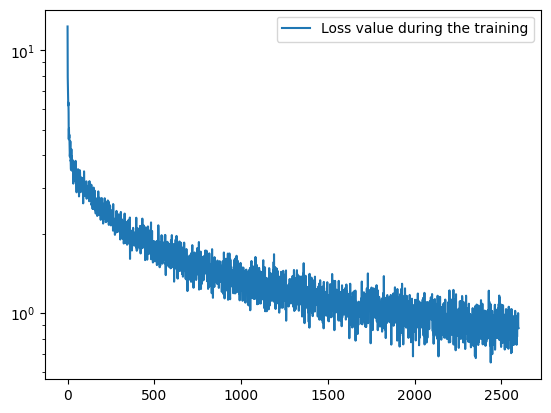

In [119]:
import matplotlib.pyplot as plt

plt.plot(train_metrics_history["train_loss"], label="Loss value during the training")
plt.yscale("log")
plt.legend()

And eval set Loss and Accuracy - Accuracy does continue to rise, though it's hard-earned progress after about the 5th epoch. Based on the training statistics, it's fair to say the process starts overfitting after roughly that 5th epoch.

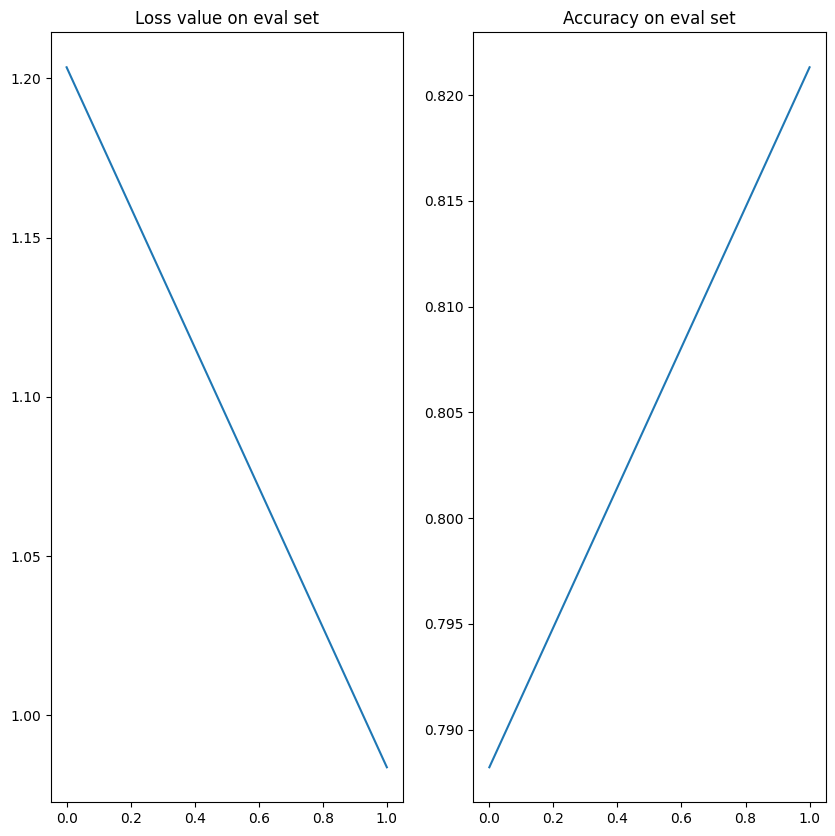

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title("Loss value on eval set")
axs[0].plot(eval_metrics_history["test_loss"])
axs[1].set_title("Accuracy on eval set")
axs[1].plot(eval_metrics_history["test_accuracy"])

## Use Model for Inference
After all that, the product of what we were working for: a trained model we can save and load for inference. For people using LLMs recently, this pattern may look rather familiar: an input sentence tokenized into an array and computed 'next' token-by-token. While many recent LLMs are decoder-only, this was an encoder/decoder architecture with the very specific english-to-spanish pattern baked in.

We've changed a couple things from the source 'use' function, here - because of the tokenizer used, things like `[start]` and `[end]` are no longer single tokens - instead `[start]` is `[29563, 60] = "[start" + "]"` and `[end]` is `[58308, 60] = "[end" + "]"` - thus we start with only a single token `[start` and can't only test on `last_token = "[end"]`. Otherwise, the main change here is that the input is assumed a single sentence, rather than batch inference.

In [121]:
def decode_sequence(input_sentence):
    input_sentence = custom_standardization(input_sentence)
    tokenized_input_sentence = tokenize_and_pad(input_sentence, tokenizer, sequence_length)
    encoder_input = jnp.array([tokenized_input_sentence])

    emb_enc = model.positional_embedding(encoder_input)
    encoder_outputs = model.encoder(emb_enc, mask=None)

    dummy_input_shape = (1, 1, model.config.embed_dim)
    model.init_cache(dummy_input_shape)

    decoded_sentence = "[start"
    current_token_id = tokenizer.encode("[start")
    current_input = jnp.array([current_token_id])

    for i in range(sequence_length):
        logits = model.decode_step(current_input, encoder_outputs, step_index=i)

        sampled_id = np.argmax(logits[0, 0, :]).item()
        sampled_token = tokenizer.decode([sampled_id])

        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break

        # Update input for next loop
        current_input = jnp.array([[sampled_id]])

    return decoded_sentence

In [122]:
test_eng_texts = [pair[0] for pair in test_pairs]

In [123]:
test_result_pairs = []
for _ in range(10):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

    test_result_pairs.append(f"[Input]: {input_sentence} [Translation]: {translated}")

## Test Results
For the model and the data, not too shabby - It's definitely spanish-ish. Though when 'making' friends, please don't confuse 'hacer' (to make) with 'comer' (to eat).

In [124]:
for i in test_result_pairs:
    print(i)

[Input]: Japan's population is larger than that of Britain and France put together. [Translation]: [start ]  la  pobl ando  fr ancia  y  fr ancia  y  fr ancia  y  fr ancia  y  fr ancia  y  la
[Input]: This time you went too far. [Translation]: [start ]  esta  vez  esta ión  [ ! ! ! ! ! ! ! ! ! ! !  esta ión  [
[Input]: She's made up her mind and refuses to be talked out of it. [Translation]: [start ]  se ó  que  se ó  y  se ó  que  se ó  [ ! !  lo  se ó  que  se
[Input]: I prefer to read. [Translation]: [start ]  pref !  me  gusta  [ ! ! ! ! ! ! ! ! ! ! !  pref ir  [
[Input]: I need a new wardrobe. [Translation]: [start ]  neces  un  nuevo  [ ! ! ! ! ! ! ! ! ! ! ! !  neces idad  [
[Input]: This mall is so big that I can't find the exit. [Translation]: [start ]  este o  es  tan  que  no  puedo ar  el  único  [ ! ! ! ! !  este o  no
[Input]: We made him go there. [Translation]: [start ]  nos amos  [ ! ! ! ! ! ! !  [ ! ! ! ! !  le  invit  [
[Input]: Didn't you hear the doorbell? [Translat

Example output from the above cell:

      [Input]: Take this medicine after meals. [Translation]: [start] toma esta medicina después de comer [end]
      [Input]: The English are said to be conservative. [Translation]: [start] el inglés son dijo que sería conservadores [end]
      [Input]: Tom might call Mary tonight. [Translation]: [start] tom quizás podría llamar a mary esta noche [end]
      [Input]: I have not finished lunch. [Translation]: [start] no he finalmente terminado [end]
      [Input]: Are you ready to start? [Translation]: [start] estás listo para empezar [end]
      [Input]: Tom worked as a lifeguard during the summer. [Translation]: [start] tom trabajó como un salvavidas durante el verano [end]
      [Input]: Can I pay later? [Translation]: [start] puedo pagar más tarde [end]
      [Input]: They went hand in hand. [Translation]: [start] ellos se fueron [end]
      [Input]: You look like a baboon. [Translation]: [start] parecés como un papión [end]
      [Input]: A cloud floated across the sky. [Translation]: [start] una sola nubeió en el cielo [end]